In [30]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import jellyfish  # Замість fuzzy використовуємо jellyfish для Soundex
import skfuzzy as fuzz_sk
from skfuzzy import control as ctrl
from Levenshtein import distance as levenshtein_distance
from tabulate import tabulate  # Для форматування таблиці результатів

# Завантаження датасету
# Припускаємо, що ваш датасет має дві колонки: "Expedia" та "Booking.com"
df = pd.read_csv("data/room_type.csv", header=None, names=["Expedia", "Booking.com"])

# Функція для обчислення метрик
def calculate_metrics(term1, term2):
    # Jaro-Winkler схожість (0-1)
    jw = fuzz.token_sort_ratio(term1, term2) / 100
    
    # Фонетична схожість за допомогою jellyfish.soundex
    snd1, snd2 = jellyfish.soundex(term1), jellyfish.soundex(term2)
    # Якщо Soundex коди однакові, вважаємо повну схожість (1.0),
    # інакше обчислюємо часткову схожість за допомогою rapidfuzz
    soundex = 1.0 if snd1 == snd2 else fuzz.ratio(snd1, snd2) / 100
    
    # Damerau-Levenshtein відстань
    dl = levenshtein_distance(term1, term2)
    
    # Довжина термінів
    length1, length2 = len(term1), len(term2)
    return jw, soundex, dl, length1, length2

# Нечітка логіка: визначення вхідних і вихідних змінних
# Вхідні змінні
jw_sim = ctrl.Antecedent(np.arange(0, 1.1, 0.1), "Jaro-Winkler")  # Схожість за Jaro-Winkler
soundex_sim = ctrl.Antecedent(np.arange(0, 1.1, 0.1), "Soundex")  # Фонетична схожість
length_diff = ctrl.Antecedent(np.arange(0, 51, 1), "Length Difference")  # Різниця в довжині термінів

# Вихідна змінна: ймовірність належності (0-100%)
similarity = ctrl.Consequent(np.arange(0, 101, 1), "Similarity")

# Функції належності для Jaro-Winkler
jw_sim["low"] = fuzz_sk.trimf(jw_sim.universe, [0, 0, 0.5])
jw_sim["medium"] = fuzz_sk.trimf(jw_sim.universe, [0.4, 0.6, 0.8])
jw_sim["high"] = fuzz_sk.trimf(jw_sim.universe, [0.7, 1, 1])

# Функції належності для Soundex
soundex_sim["none"] = fuzz_sk.trimf(soundex_sim.universe, [0, 0, 0.3])
soundex_sim["partial"] = fuzz_sk.trimf(soundex_sim.universe, [0.2, 0.5, 0.7])
soundex_sim["full"] = fuzz_sk.trimf(soundex_sim.universe, [0.6, 1, 1])

# Функції належності для різниці в довжині
length_diff["small"] = fuzz_sk.trimf(length_diff.universe, [0, 0, 10])
length_diff["medium"] = fuzz_sk.trimf(length_diff.universe, [5, 15, 25])
length_diff["large"] = fuzz_sk.trimf(length_diff.universe, [20, 50, 50])

# Функції належності для вихідної змінної (ймовірність)
similarity["low"] = fuzz_sk.trimf(similarity.universe, [0, 0, 40])
similarity["medium"] = fuzz_sk.trimf(similarity.universe, [30, 50, 70])
similarity["high"] = fuzz_sk.trimf(similarity.universe, [60, 100, 100])

# Правила нечіткого виведення
rule1 = ctrl.Rule(jw_sim["high"] & soundex_sim["full"], similarity["high"])
rule2 = ctrl.Rule(jw_sim["medium"] & length_diff["small"], similarity["medium"])
rule3 = ctrl.Rule(jw_sim["low"] & soundex_sim["none"], similarity["low"])

# Створення системи нечіткого керування
system = ctrl.ControlSystem([rule1, rule2, rule3])
simulator = ctrl.ControlSystemSimulation(system)

# Аналіз пар термінів
results = []
for i, row in df.iterrows():
    term1, term2 = row["Expedia"], row["Booking.com"]
    
    # Обчислення метрик
    jw, snd, dl, len1, len2 = calculate_metrics(term1, term2)
    length_diff_val = abs(len1 - len2)
    
    # Встановлення вхідних значень для нечіткої системи
    simulator.input["Jaro-Winkler"] = jw
    simulator.input["Soundex"] = snd
    simulator.input["Length Difference"] = length_diff_val
    
    # Обчислення ймовірності
    simulator.compute()
    
    # Отримання результату
    prob = simulator.output["Similarity"]
    decision = "Належить" if prob >= 70 else "Не належить"
    
    # Збереження результатів
    results.append([term1, term2, f"{jw:.2f}", f"{snd:.2f}", dl, f"{prob:.0f}%", decision])

# Виведення результатів у вигляді таблиці
print(tabulate(results, headers=["Термін 1", "Термін 2", "Jaro-Winkler", "Soundex", "Damerau-Levenshtein", "Ймовірність", "Рішення"], tablefmt="grid"))

# Сортування результатів за ймовірністю та виведення топ-10
results_sorted = sorted(results, key=lambda x: float(x[5].strip("%")), reverse=True)[:10]
print("\nТоп-10 пар за ймовірністю належності:")
print(tabulate(results_sorted, headers=["Термін 1", "Термін 2", "Jaro-Winkler", "Soundex", "Damerau-Levenshtein", "Ймовірність", "Рішення"], tablefmt="grid"))

KeyError: 'Similarity'

In [29]:
pip install fuzzy

  Using cached Fuzzy-1.2.2.tar.gz (14 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for fuzzy
Failed to build fuzzy
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [41 lines of output]
      c:\Users\Mykhailo\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
      [04/05/25 23:03:46] WARNING  toml section missing       pyproject_reading.py:42
                                   'pyproject.toml does not
                                   contain a
                                   tool.setuptools_scm
  

In [1]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import jellyfish
import matplotlib.pyplot as plt
from tabulate import tabulate
from Levenshtein import distance as levenshtein_distance

In [3]:
# Завантаження датасету
file_path = 'data/room_type.csv'
df_full = pd.read_csv(file_path)

# Перегляд у форматі таблички
df_full.head(105).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
)

,Expedia,Booking.com
0,"Deluxe Room, 1 King Bed",Deluxe King Room
1,"Standard Room, 1 King Bed, Accessible",Standard King Roll-in Shower Accessible
2,"Grand Corner King Room, 1 King Bed",Grand Corner King Room
3,"Suite, 1 King Bed (Parlor)",King Parlor Suite
4,"High-Floor Premium Room, 1 King Bed",High-Floor Premium King Room
5,"Traditional Double Room, 2 Double Beds",Double Room with Two Double Beds
6,"Room, 1 King Bed, Accessible",King Room - Disability Access
7,"Deluxe Room, 1 King Bed",Deluxe King Room
8,Deluxe Room,Deluxe Room (Non Refundable)
9,"Room, 2 Double Beds (19th to 25th Floors)",Two Double Beds - Location Room (19th to 25th Floors)


In [4]:
# Перейменування колонок
df_full.columns = ['Expedia', 'Booking']

In [5]:
# Перевірка назв колонок
print("\nСписок колонок у датасеті:")
print(list(df_full.columns))


Список колонок у датасеті:
['Expedia', 'Booking']


In [6]:
# Використовуємо повний датасет
df = df_full[['Expedia', 'Booking']].copy()
df['ID'] = range(1, len(df) + 1)  # Додаємо колонку ID
df = df[['ID', 'Expedia', 'Booking']]  # Переставляємо колонку ID на початок

In [7]:
df.head(5).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
)

,ID,Expedia,Booking
0,1,"Deluxe Room, 1 King Bed",Deluxe King Room
1,2,"Standard Room, 1 King Bed, Accessible",Standard King Roll-in Shower Accessible
2,3,"Grand Corner King Room, 1 King Bed",Grand Corner King Room
3,4,"Suite, 1 King Bed (Parlor)",King Parlor Suite
4,5,"High-Floor Premium Room, 1 King Bed",High-Floor Premium King Room


In [8]:
print(f"\nКількість записів: {len(df)}")


Кількість записів: 103


In [27]:
# Крок 1: Визначення вхідних параметрів
# Функція для обчислення довжини терміну
def term_length(term):
    if pd.isna(term):  # Обробка NaN
        return 0
    return len(str(term).split())  # Кількість слів у терміні

# Функція для обчислення метрик схожості
def calculate_metrics(term1, term2):
    if pd.isna(term1) or pd.isna(term2):  # Обробка NaN
        return 0, 0, 0
    # Використовуємо fuzzywuzzy.fuzz для Jaro-Winkler
    jaro_winkler = fuzz.token_sort_ratio(str(term1), str(term2)) / 100  # Нормалізація до 0-1
    soundex_score = 1 if jellyfish.soundex(str(term1)) == jellyfish.soundex(str(term2)) else 0
    dl_distance = levenshtein_distance(str(term1), str(term2))
    max_len = max(len(str(term1)), len(str(term2)))
    dl_similarity = 1 - (dl_distance / max_len) if max_len > 0 else 0  # Нормалізація до 0-1
    return jaro_winkler, soundex_score, dl_similarity

# Додаємо колонки з параметрами до датасету
df['Length_Expedia'] = df['Expedia'].apply(term_length)
df['Length_Booking'] = df['Booking'].apply(term_length)
df['Jaro_Winkler'] = df.apply(lambda row: calculate_metrics(row['Expedia'], row['Booking'])[0], axis=1)
df['Soundex'] = df.apply(lambda row: calculate_metrics(row['Expedia'], row['Booking'])[1], axis=1)
df['Damerau_Levenshtein'] = df.apply(lambda row: calculate_metrics(row['Expedia'], row['Booking'])[2], axis=1)

AttributeError: module 'skfuzzy' has no attribute 'token_sort_ratio'

In [14]:
# Додаємо довжину термінів (кількість слів)
df['expedia_length'] = df['Expedia'].apply(lambda x: len(str(x).split()))
df['booking_length'] = df['Booking'].apply(lambda x: len(str(x).split()))
df['avg_length'] = (df['expedia_length'] + df['booking_length']) / 2

def classify_length(length):
    if length <= 3:
        return 'короткий'
    elif length <= 6:
        return 'середній'
    else:
        return 'довгий'

df['expedia_length_class'] = df['expedia_length'].apply(classify_length)
df['booking_length_class'] = df['booking_length'].apply(classify_length)
df['length_class'] = df['avg_length'].apply(classify_length)

print("\nДатасет із класифікацією довжини термінів:")
table = tabulate(df[['ID', 'Expedia', 'expedia_length_class', 'Booking', 'booking_length_class', 'length_class']].head(20),  
                 headers='keys', tablefmt='pretty')

print(table)


Датасет із класифікацією довжини термінів:
+----+----+-------------------------------------------+----------------------+-------------------------------------------------------+----------------------+--------------+
|    | ID |                  Expedia                  | expedia_length_class |                        Booking                        | booking_length_class | length_class |
+----+----+-------------------------------------------+----------------------+-------------------------------------------------------+----------------------+--------------+
| 0  | 1  |          Deluxe Room, 1 King Bed          |       середній       |                   Deluxe King Room                    |       короткий       |   середній   |
| 1  | 2  |   Standard Room, 1 King Bed, Accessible   |       середній       |        Standard King Roll-in Shower Accessible        |       середній       |   середній   |
| 2  | 3  |    Grand Corner King Room, 1 King Bed     |        довгий        |             

In [15]:
# Функція для обчислення Soundex
def soundex_similarity(str1, str2):
    return int(jellyfish.soundex(str1) == jellyfish.soundex(str2))

# Функція для обчислення метрик
def calculate_metrics(str1, str2):
    jw = fuzz.token_sort_ratio(str1, str2) / 100  # Jaro-Winkler (0–1)
    sndx = soundex_similarity(str1, str2)  # Soundex (0 або 1)
    dl = levenshtein_distance(str1, str2)  # Damerau-Levenshtein (ціле число)
    return jw, sndx, dl

# Додати метрики до DataFrame
df[['jaro_winkler', 'soundex', 'damerau_levenshtein']] = df.apply(
    lambda row: pd.Series(calculate_metrics(row['Expedia'], row['Booking'])), axis=1
)

# Переглянути результат
print("\nДатасет із метриками схожості:")
table = tabulate(df[['ID', 'Expedia', 'Booking', 'length_class', 'jaro_winkler', 'soundex', 'damerau_levenshtein']].head(10), 
                 headers='keys', tablefmt='pretty')
print(table)


Датасет із метриками схожості:
+---+----+-------------------------------------------+-------------------------------------------------------+--------------+--------------------+---------+---------------------+
|   | ID |                  Expedia                  |                        Booking                        | length_class |    jaro_winkler    | soundex | damerau_levenshtein |
+---+----+-------------------------------------------+-------------------------------------------------------+--------------+--------------------+---------+---------------------+
| 0 | 1  |          Deluxe Room, 1 King Bed          |                   Deluxe King Room                    |   середній   | 0.8205128205128205 |   0.0   |        12.0         |
| 1 | 2  |   Standard Room, 1 King Bed, Accessible   |        Standard King Roll-in Shower Accessible        |   середній   | 0.736842105263158  |   1.0   |        17.0         |
| 2 | 3  |    Grand Corner King Room, 1 King Bed     |                Gra

In [11]:
# Візуалізація розподілу метрик
def plot_metrics_distribution(df):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(df['jaro_winkler'], bins=20, color='blue', alpha=0.7)
    plt.title('Розподіл Jaro-Winkler')
    plt.xlabel('Значення')
    plt.ylabel('Кількість пар')
    
    plt.subplot(1, 3, 2)
    plt.hist(df['soundex'], bins=2, color='green', alpha=0.7)
    plt.title('Розподіл Soundex')
    plt.xlabel('Значення (0 або 1)')
    plt.ylabel('Кількість пар')
    
    plt.subplot(1, 3, 3)
    plt.hist(df['damerau_levenshtein'], bins=20, color='red', alpha=0.7)
    plt.title('Розподіл Damerau-Levenshtein')
    plt.xlabel('Значення')
    plt.ylabel('Кількість пар')
    
    plt.tight_layout()
    plt.show()

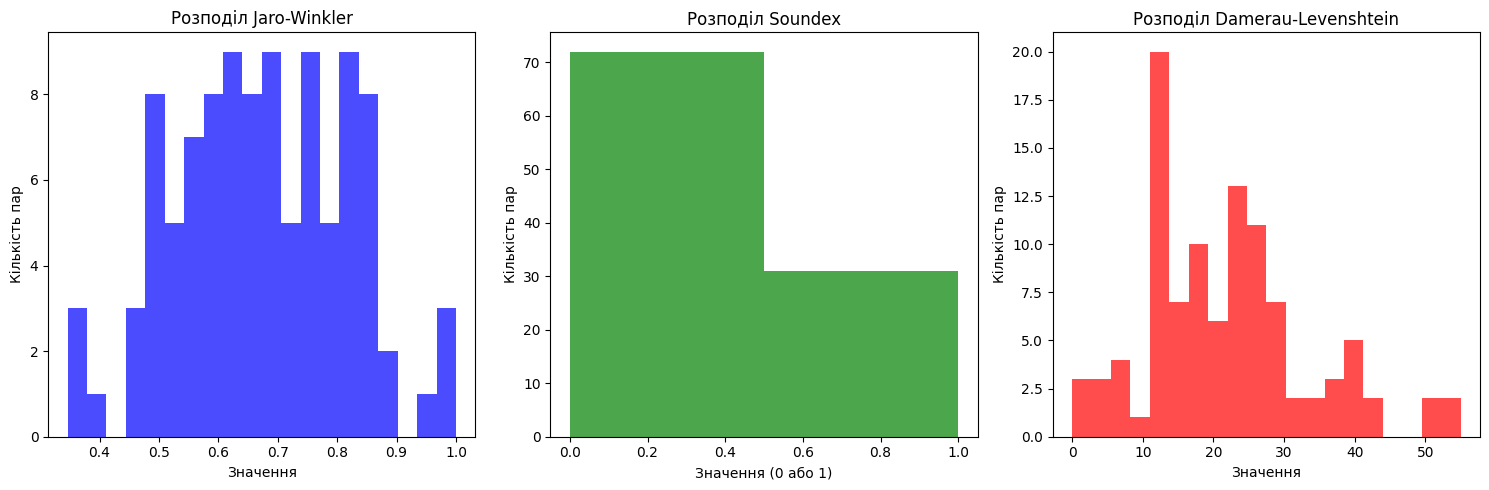

In [12]:
plot_metrics_distribution(df)

In [21]:
from skfuzzy import control as ctrl
import numpy as np

# Діапазони для функцій належності
jw_range = np.arange(0, 1.01, 0.01)
sndx_range = np.arange(0, 1.01, 0.01)
dl_range = np.arange(0, 1.01, 0.01)

# Вхідні змінні
jw = ctrl.Antecedent(jw_range, 'jaro_winkler')
sndx = ctrl.Antecedent(sndx_range, 'soundex')
dl = ctrl.Antecedent(dl_range, 'damerau_levenshtein')

# Нечіткі множини для вхідних змінних
jw['low'] = fuzz.trimf(jw_range, [0, 0, 0.5])
jw['med'] = fuzz.trimf(jw_range, [0.4, 0.6, 0.8])
jw['high'] = fuzz.trimf(jw_range, [0.7, 1, 1])

sndx['none'] = fuzz.trimf(sndx_range, [0, 0, 0.5])
sndx['full'] = fuzz.trimf(sndx_range, [0.5, 1, 1])

dl['low'] = fuzz.trimf(dl_range, [0, 0, 0.3])
dl['med'] = fuzz.trimf(dl_range, [0.2, 0.4, 0.6])
dl['high'] = fuzz.trimf(dl_range, [0.5, 1, 1])

# Вихідна змінна (ймовірність належності)
similarity = ctrl.Consequent(np.arange(0, 101, 1), 'similarity')
similarity['low'] = fuzz.trimf(similarity.universe, [0, 0, 50])
similarity['high'] = fuzz.trimf(similarity.universe, [50, 100, 100])

# Правила
rule1 = ctrl.Rule(jw['high'] & sndx['full'], similarity['high'])
rule2 = ctrl.Rule(jw['med'] & dl['high'], similarity['high'])
rule3 = ctrl.Rule(jw['low'] & sndx['none'], similarity['low'])

# Система керування
sim_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
sim_sim = ctrl.ControlSystemSimulation(sim_ctrl)

# Функція для обчислення схожості
def compute_similarity(row):
    sim_sim.input['jaro_winkler'] = row['jaro_winkler']
    sim_sim.input['soundex'] = row['soundex']
    sim_sim.input['damerau_levenshtein'] = row['norm_dl']
    sim_sim.compute()
    return sim_sim.output['similarity']

# Обчислення для кожної пари
df['similarity'] = df.apply(compute_similarity, axis=1)

# Рішення
threshold = 70
df['decision'] = df['similarity'].apply(lambda x: 'Належить' if x >= threshold else 'Не належить')

# Топ-10 пар
print("\nТоп-10 пар:")
print(tabulate(df[['ID', 'Expedia', 'Booking', 'similarity', 'decision']].head(10), headers='keys', tablefmt='pretty'))

KeyError: 'similarity'

In [20]:
from skfuzzy import control as ctrl

# Вхідні змінні
jw = ctrl.Antecedent(jw_range, 'jaro_winkler')
sndx = ctrl.Antecedent(sndx_range, 'soundex')
dl = ctrl.Antecedent(dl_range, 'damerau_levenshtein')

# Вихідна змінна (ймовірність належності)
similarity = ctrl.Consequent(np.arange(0, 101, 1), 'similarity')
similarity['low'] = fuzz.trimf(similarity.universe, [0, 0, 50])
similarity['high'] = fuzz.trimf(similarity.universe, [50, 100, 100])

# Правила
rule1 = ctrl.Rule(jw['high'] & sndx['full'], similarity['high'])
rule2 = ctrl.Rule(jw['med'] & dl['high'], similarity['high'])
rule3 = ctrl.Rule(jw['low'] & sndx['none'], similarity['low'])

# Система керування
sim_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
sim_sim = ctrl.ControlSystemSimulation(sim_ctrl)

# Обчислення для кожної пари
df['similarity'] = df.apply(
    lambda row: sim_sim.input['jaro_winkler'] = row['jaro_winkler'];
                sim_sim.input['soundex'] = row['soundex'];
                sim_sim.input['damerau_levenshtein'] = row['norm_dl'];
                sim_sim.compute();
                sim_sim.output['similarity'], axis=1)

# Рішення
threshold = 70
df['decision'] = df['similarity'].apply(lambda x: 'Належить' if x >= threshold else 'Не належить')

# Топ-10 пар
print("\nТоп-10 пар:")
print(tabulate(df[['ID', 'Expedia', 'Booking', 'similarity', 'decision']].head(10), headers='keys', tablefmt='pretty'))

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (2027818249.py, line 24)

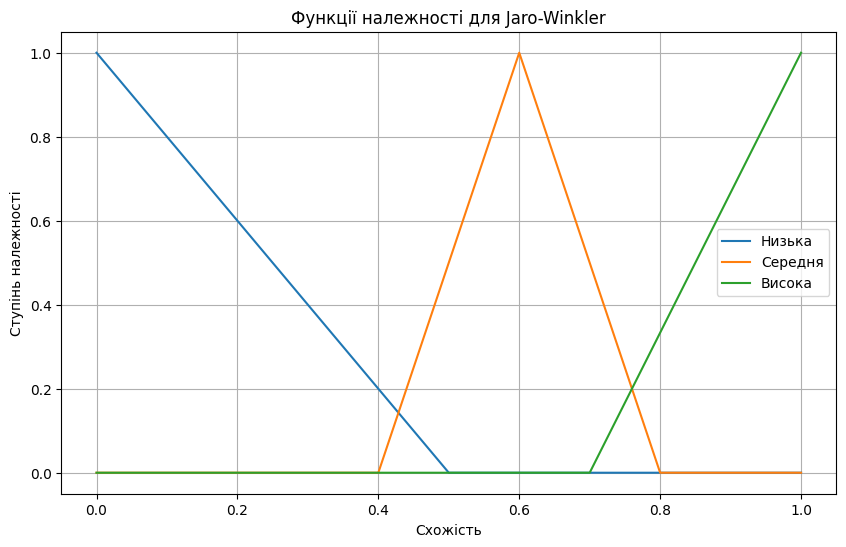

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(jw_range, jw_low, label='Низька')
plt.plot(jw_range, jw_med, label='Середня')
plt.plot(jw_range, jw_high, label='Висока')
plt.title('Функції належності для Jaro-Winkler')
plt.xlabel('Схожість')
plt.ylabel('Ступінь належності')
plt.legend()
plt.grid(True)
plt.show()